In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

from lmphoton.simulation import current_simulation as sim

from tqdm import tqdm

from scipy.optimize import minimize
from functools import partial

from interleavers import Interleaver
interleaver = Interleaver()
um=1e-6

100%|██████████| 10001/10001 [00:02<00:00, 3816.34it/s]


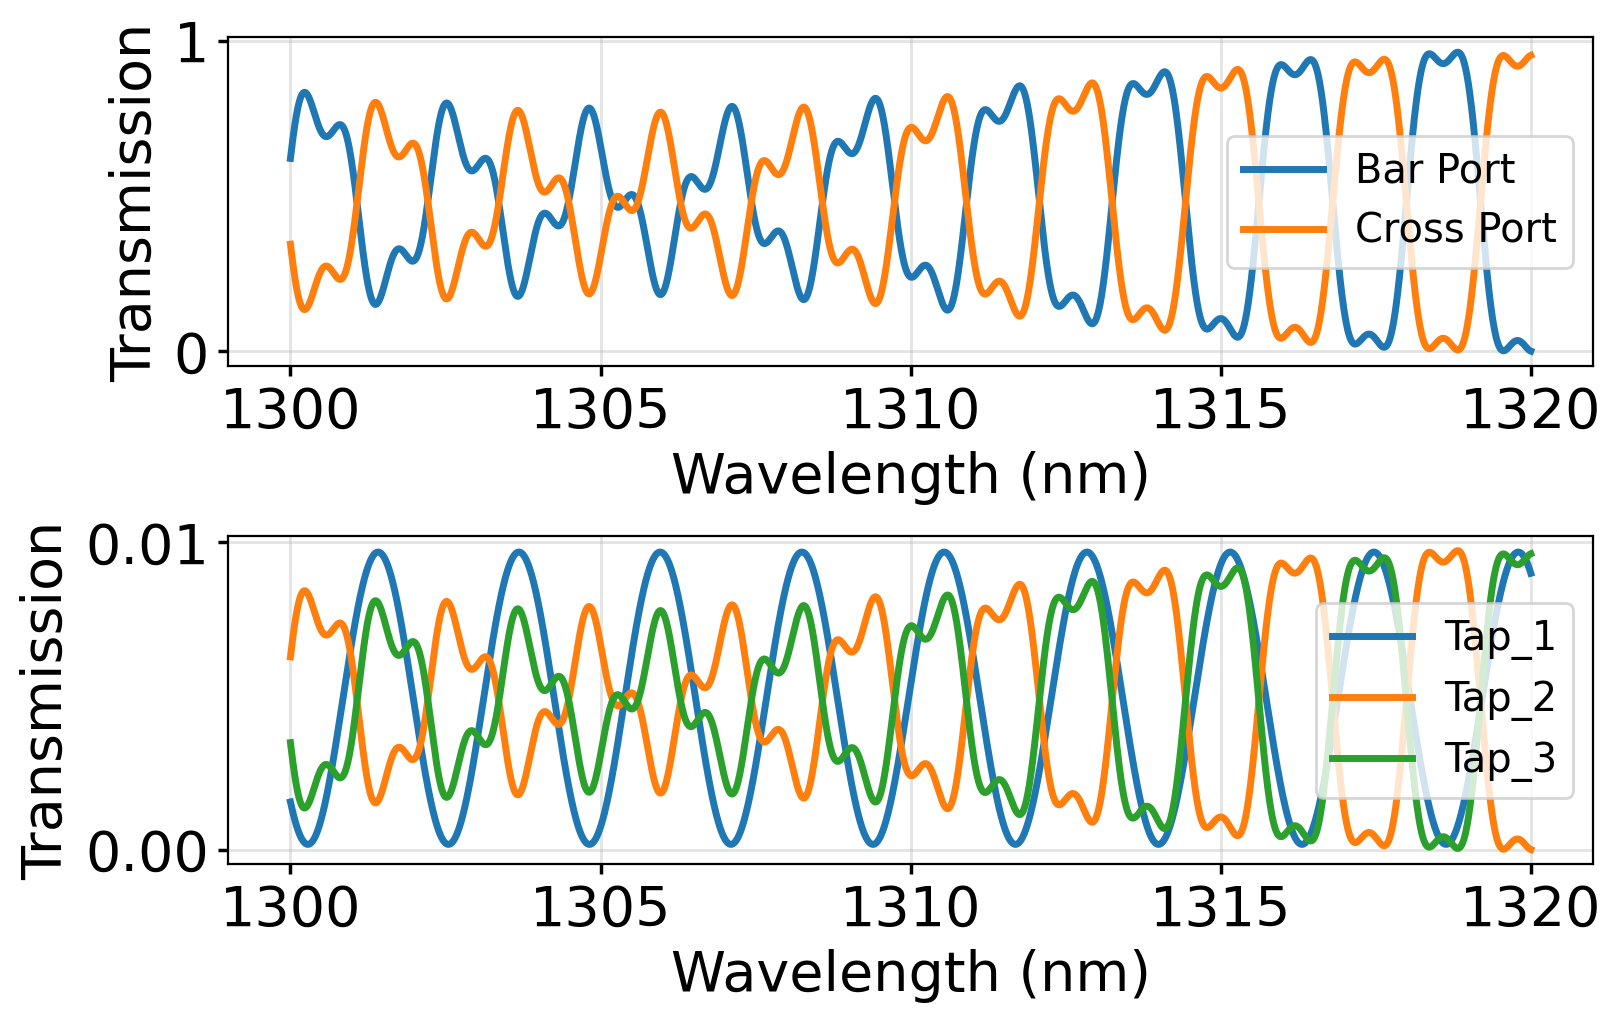

In [2]:
# Broad wavelength sweeps of the interleaver
wavelengths = np.linspace(1.3, 1.32, 10001)*um 

interleaver.XPS0.heater_voltage = 0.0
interleaver.XPS1.heater_voltage = 0.0
interleaver.XPS2.heater_voltage = 0.0
interleaver.XPS3.heater_voltage = 0.0

bar_port_tx = []
cross_port_tx = []

tap_1_tx = []
tap_2_tx = []
tap_3_tx = []

for wavelength in tqdm(wavelengths):
  sim().wavelength = wavelength
  interleaver._wavelegth = wavelength
  s_matrix = interleaver.smatrix
  bar_port_tx.append(np.real(s_matrix * np.conj(s_matrix))[4,0])
  cross_port_tx.append(np.real(s_matrix * np.conj(s_matrix))[6,0])

  tap_1_tx.append(np.real(s_matrix * np.conj(s_matrix))[2,0])
  tap_2_tx.append(np.real(s_matrix * np.conj(s_matrix))[3,0])
  tap_3_tx.append(np.real(s_matrix * np.conj(s_matrix))[5,0])

plt.figure()
plt.subplot(2,1,1)
plt.plot(wavelengths*1e9,bar_port_tx)
plt.plot(wavelengths*1e9,cross_port_tx)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend(["Bar Port","Cross Port"])
plt.subplot(2,1,2)
plt.plot(wavelengths*1e9,tap_1_tx)
plt.plot(wavelengths*1e9,tap_2_tx)
plt.plot(wavelengths*1e9,tap_3_tx)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend(["Tap_1","Tap_2","Tap_3"])
plt.show()

In [3]:
def calculate_optimal_transfer_function():
    optimal_transfer_function = np.array(
        [
            int(1*(i- 1310e-9 - interleaver.channel_spacing/2)/interleaver.channel_spacing % 2) for i in wavelengths
        ]
    )
    return optimal_transfer_function

def calculate_cost_function(param_list, info, printy=False):
    dc0, dc1, dc2, voltage0, voltage1 = param_list
    
    interleaver.XPS0.heater_voltage = voltage0
    interleaver.XPS1.heater_voltage = 0.0
    interleaver.XPS2.heater_voltage = voltage1
    interleaver.XPS3.heater_voltage = 0.0
    
    interleaver.dc0._splitratio = dc0
    interleaver.dc1._splitratio = dc1
    interleaver.dc2._splitratio = dc2

    bar_port_response = []
    cross_port_response = []

    for wavelength in wavelengths:
      sim().wavelength = wavelength
      interleaver._wavelegth = wavelength
      s_matrix = interleaver.smatrix
      bar_port_response.append(np.real(s_matrix * np.conj(s_matrix))[4,0])
      cross_port_response.append(np.real(s_matrix * np.conj(s_matrix))[6,0])
      
    cost = np.sum(np.abs(calculate_optimal_transfer_function() - bar_port_response)) 
    cost += np.sum(np.abs(1 - calculate_optimal_transfer_function() - cross_port_response)) # 1 - is to flip the response for the cross port. #I'm summing both the bar and cross response to give equally weighting to pass and stop bands

    # display information
    if (info['Nfeval'] == 0) and (printy == True):
        print("  #      DC0        DC1        DC2       Voltage0      Voltage1       Cost")
    if (info['Nfeval']%10 == 0) and (printy == True):
        print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}  {6: 3.6f}'.format(
            info['Nfeval'],
            dc0,
            dc1,
            dc2,
            voltage0,
            voltage1,
            cost
        )
    )
    info['Nfeval'] += 1
    return cost

In [4]:
def minimize_cost_function(
          bounds_epsilon = 0.05,
          random_dc = False,
          random_phase=True,
          printy = False
    ):
        initial_condition = []
        bounds = []

        if random_dc == True:
            for _ in range(3):
                initial_condition.append(np.random.rand())
                bounds.append((0,1))
        elif random_dc == False:
            initial_condition.append(interleaver.dc0._splitratio)
            initial_condition.append(interleaver.dc1._splitratio)
            initial_condition.append(interleaver.dc2._splitratio)

            bounds.append(
                (interleaver.dc0._splitratio - bounds_epsilon, interleaver.dc0._splitratio + bounds_epsilon)
                )
            bounds.append(
                (interleaver.dc1._splitratio - bounds_epsilon, interleaver.dc1._splitratio + bounds_epsilon)
                )
            bounds.append(
                (interleaver.dc2._splitratio - bounds_epsilon,interleaver.dc2._splitratio + bounds_epsilon)
                )
        if random_phase == True:
            for _ in range(2):
                initial_condition.append(5.32*(np.random.rand()))
                bounds.append((0, 5.32))
        elif random_phase == False:
            initial_condition.append(interleaver.XPS0.heater_voltage)
            initial_condition.append(interleaver.XPS2.heater_voltage)
            bounds.append(
                (interleaver.XPS0.heater_voltage - bounds_epsilon, interleaver.XPS0.heater_voltage + bounds_epsilon)
                )
            bounds.append(
                (interleaver.XPS2.heater_voltage - bounds_epsilon, interleaver.XPS2.heater_voltage + bounds_epsilon)
                )
            
        result = minimize(
            partial(calculate_cost_function, printy=printy),
            initial_condition,
            method='Nelder-Mead',
            bounds=bounds,
            args=({'Nfeval': 0}),
            options={
                "maxiter": 1000,
                'xatol': 1e-3,
                'fatol': 1e-3,
            },
        )

        return result

In [5]:
result = minimize_cost_function(
          bounds_epsilon = 1e-3,
          random_dc = False,
          random_phase=True,
          printy = True
    )

  #      DC0        DC1        DC2       Voltage0      Voltage1       Cost
   0    0.500000    0.630000    0.900000    0.928968  2.161794   8098.605120
  10    0.499640    0.629040    0.901000    0.991395  2.307066   7711.679699
  20    0.499000    0.629509    0.899000    1.276001  2.773254   6240.845226
  30    0.499312    0.629724    0.900342    1.956979  4.194423   4710.785486
  40    0.499000    0.629522    0.900085    1.566107  3.422773   4807.826304
  50    0.499331    0.629877    0.899441    1.779400  4.178092   4370.206834
  60    0.499388    0.629641    0.899949    1.771430  4.098867   4356.262529
  70    0.499230    0.629791    0.899828    1.738125  4.120618   4342.099606
  80    0.499185    0.629815    0.899706    1.714474  4.044430   4339.291434
  90    0.499134    0.629814    0.899955    1.727594  4.109430   4338.704221
 100    0.499013    0.629838    0.900077    1.702377  4.069985   4337.017744
 110    0.499017    0.629895    0.900893    1.702145  4.057271   4331.222024
 

In [6]:
# Broad wavelength sweeps of the interleaver
wavelengths = np.linspace(1.3, 1.32, 10001)*um 

interleaver.XPS0.heater_voltage = result.x[3]
interleaver.XPS2.heater_voltage = result.x[4]

optimized_bar_port_tx = []
optimized_cross_port_tx = []

optimized_tap_1_tx = []
optimized_tap_2_tx = []
optimized_tap_3_tx = []

for wavelength in tqdm(wavelengths):
  sim().wavelength = wavelength
  interleaver._wavelegth = wavelength
  s_matrix = interleaver.smatrix
  optimized_bar_port_tx.append(np.real(s_matrix * np.conj(s_matrix))[4,0])
  optimized_cross_port_tx.append(np.real(s_matrix * np.conj(s_matrix))[6,0])

  optimized_tap_1_tx.append(np.real(s_matrix * np.conj(s_matrix))[2,0])
  optimized_tap_2_tx.append(np.real(s_matrix * np.conj(s_matrix))[3,0])
  optimized_tap_3_tx.append(np.real(s_matrix * np.conj(s_matrix))[5,0])

100%|██████████| 10001/10001 [00:02<00:00, 3777.42it/s]


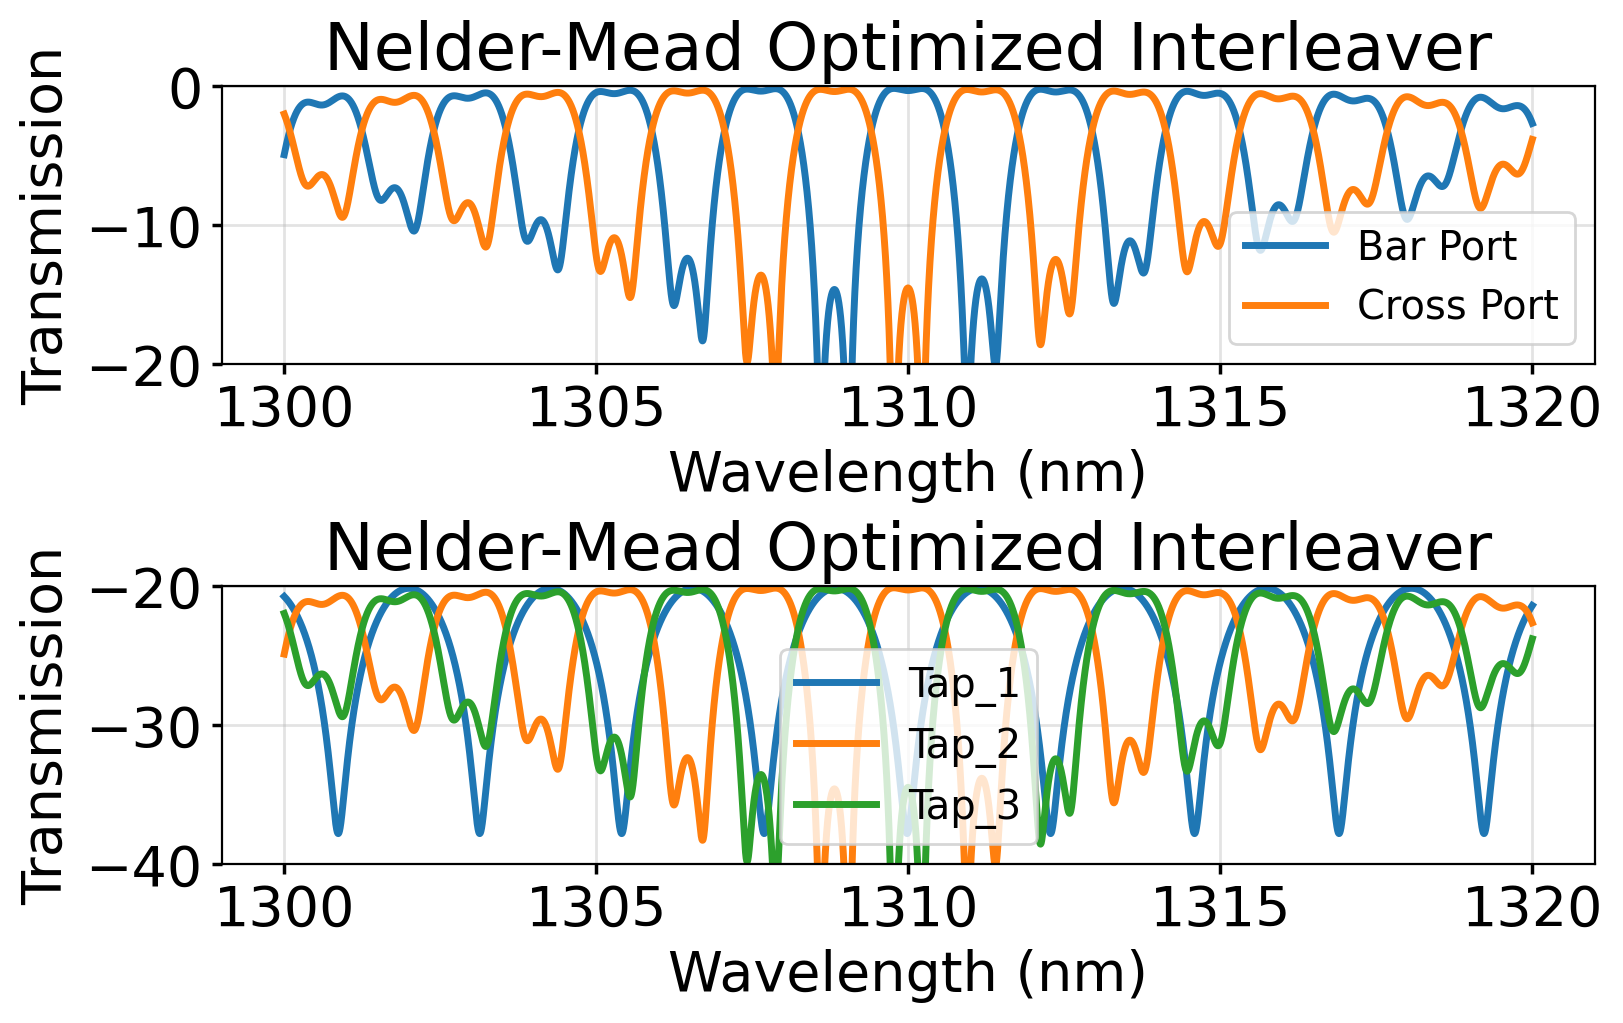

<Figure size 1600x1000 with 0 Axes>

In [7]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(wavelengths*1e9,10*np.log10(optimized_bar_port_tx))
plt.plot(wavelengths*1e9,10*np.log10(optimized_cross_port_tx))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend(["Bar Port","Cross Port"])
plt.title("Nelder-Mead Optimized Interleaver")
plt.ylim([-20,0])
plt.subplot(2,1,2)
plt.plot(wavelengths*1e9,10*np.log10(optimized_tap_1_tx))
plt.plot(wavelengths*1e9,10*np.log10(optimized_tap_2_tx))
plt.plot(wavelengths*1e9,10*np.log10(optimized_tap_3_tx))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend(["Tap_1","Tap_2","Tap_3"])
plt.title("Nelder-Mead Optimized Interleaver")
plt.ylim([-40,-20])
plt.show()
plt.tight_layout()